In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

import pickle
import mlflow
import time
import xgbfir

import optuna
import optuna.visualization as vis

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

# Scalers
from sklearn.preprocessing import label_binarize

from imblearn.over_sampling import SMOTE, ADASYN

# Metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, auc, roc_curve, precision_recall_curve, f1_score, confusion_matrix, balanced_accuracy_score, cohen_kappa_score, log_loss 

# Model
from xgboost import XGBClassifier, plot_importance

# Model Selection - XGBoost

## 1. Load Data

In [2]:
attributes = pd.read_csv("data/btc_price_data_1_year_attributes.csv")
attributes.set_index('timestamp', inplace=True, drop = True)
attributes

,open,high,low,close,volume,month,day,weekday,hour,hour_sin,...,lag_47,lag_56,RSI,EMA12,EMA26,MACD,Signal_Line,SMA,EMA,future_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-01 00:56:00,34524.12,34549.26,34541.45,34524.49,31.117144,11,1,2,0,0.000000,...,34619.47,34667.88,47.431310,34542.664324,34556.581568,-13.917244,-12.759288,34553.5310,34550.874620,0.000377
2023-11-01 00:57:00,34524.13,34537.66,34524.52,34524.62,7.349951,11,1,2,0,0.000000,...,34603.20,34642.82,48.755135,34539.888274,34554.214045,-14.325771,-13.072585,34549.4505,34548.374180,-0.005330
2023-11-01 00:58:00,34519.85,34531.41,34527.81,34522.78,5.134526,11,1,2,0,0.000000,...,34602.26,34656.56,48.265451,34537.256232,34551.885597,-14.629365,-13.383941,34545.2715,34545.936639,0.025461
2023-11-01 00:59:00,34521.42,34531.98,34521.42,34531.57,4.310564,11,1,2,0,0.000000,...,34623.10,34629.34,41.702541,34536.381427,34550.380738,-13.999311,-13.507015,34542.0065,34544.568387,0.021053
2023-11-01 01:00:00,34531.46,34547.87,34532.22,34538.84,1.327905,11,1,2,1,0.258819,...,34611.54,34622.27,48.144440,34536.759669,34549.525868,-12.766199,-13.358852,34540.4225,34544.022827,0.011263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 23:55:00,70248.97,70264.97,70248.98,70248.97,1.604753,10,31,3,23,-0.258819,...,70345.60,70383.13,15.731750,70316.514762,70363.992465,-47.477702,-35.505422,70367.7305,70348.638181,-0.014534
2024-10-31 23:56:00,70238.76,70248.97,70248.97,70238.76,1.189134,10,31,3,23,-0.258819,...,70329.38,70461.07,20.028025,70304.552491,70354.715986,-50.163495,-38.437037,70352.5490,70338.173592,-0.007859
2024-10-31 23:57:00,70218.00,70250.00,70238.77,70233.24,4.767082,10,31,3,23,-0.258819,...,70317.72,70470.15,14.761536,70293.581339,70345.717765,-52.136426,-41.176915,70338.1685,70328.179916,-0.036251


In [3]:
target_data = pd.read_csv("data/btc_price_data_1_year_target.csv")
target_data.set_index('timestamp', inplace=True, drop = True)
target = target_data['target']
target

timestamp
2023-11-01 00:56:00    0
2023-11-01 00:57:00    0
2023-11-01 00:58:00    0
2023-11-01 00:59:00    0
2023-11-01 01:00:00    0
                      ..
2024-10-31 23:55:00    0
2024-10-31 23:56:00    0
2024-10-31 23:57:00    0
2024-10-31 23:58:00    0
2024-10-31 23:59:00    0
Name: target, Length: 528575, dtype: int64

## 2. Data Splitting

In [4]:
attributes_train, attributes_test, target_train, target_test = train_test_split(
    attributes, 
    target, 
    test_size=0.2, 
    shuffle = False,
    random_state = 42
)

In [5]:
attributes_train.shape, attributes_test.shape

((422860, 52), (105715, 52))

In [6]:
target_train.shape, target_test.shape

((422860,), (105715,))

## 3. Oversampling- Address Class Imbalance

**SMOTE** (Synthetic Minority Oversampling Technique) and **ADASYN** (Adaptive Synthetic Sampling) are two popular oversampling techniques for addressing class imbalance in datasets. Both generate synthetic samples for the minority class to balance the dataset, but they differ in how they create these samples. Below is a detailed comparison to help you understand their strengths and use cases.

##### **Core Approach**

###### **SMOTE**
- **How it works**: 
  - For each minority class sample, SMOTE selects one or more nearest neighbors.
  - It creates synthetic samples by interpolating between the sample and its neighbors.
  - The interpolation is linear, producing samples along the line segments between the selected points.
- **Focus**: Generates synthetic samples evenly across the minority class.

###### **ADASYN**
- **How it works**: 
  - ADASYN builds on SMOTE by focusing more on the minority class samples that are harder to classify.
  - It identifies minority samples near the decision boundary (using k-nearest neighbors) and generates more synthetic samples in these regions.
  - The number of synthetic samples per instance is proportional to the local difficulty (measured by the density of majority class samples nearby).
- **Focus**: Creates samples adaptively, concentrating on areas where the minority class is harder to learn.

---

##### **Key Differences**

| Feature                     | **SMOTE**                                  | **ADASYN**                                      |
|-----------------------------|---------------------------------------------|------------------------------------------------|
| **Generation Strategy**     | Uniformly interpolates between samples.     | Focuses on generating samples near decision boundaries. |
| **Focus**                   | Balances the dataset evenly.               | Adaptive oversampling based on instance difficulty.      |
| **Synthetic Sample Location** | Can lead to over-generalization.           | More targeted and refined near complex regions. |
| **Computational Complexity**| Relatively lower computational cost.        | Slightly higher due to the adaptive nature.     |
| **Risk of Overfitting**     | Higher risk if the boundary is noisy.       | Reduced overfitting near decision boundaries.   |

---

##### **Strengths**

###### **SMOTE**
- **Advantages**:
  - Simple and effective for moderately imbalanced datasets.
  - Maintains the distribution of the minority class.
- **When to Use**:
  - When the imbalance is not extreme.
  - When you want a more uniform oversampling approach.

###### **ADASYN**
- **Advantages**:
  - Focuses on challenging regions, improving the model's ability to classify difficult cases.
  - Reduces the risk of overgeneralization by targeting specific areas.
- **When to Use**:
  - For highly imbalanced datasets.
  - When the minority class has complex boundaries or is under-represented in critical regions.

---

##### **Limitations**

###### **SMOTE**
- Does not consider the difficulty of classification.
- Can create synthetic samples in regions that are already well-represented, potentially leading to redundancy.
- May cause overfitting in noisy datasets.

###### **ADASYN**
- Slightly more computationally expensive than SMOTE.
- If the data is very noisy, it might generate samples in misleading or non-representative regions.


### 3.1. SMOTE (Synthetic Minority Oversampling Technique)

In [7]:
def create_oversampling_smote(attributes_train, target_train):
    """
    Apply SMOTE(Synthetic Minority Oversampling Technique) to generate synthetic examples for minority classes
    """
    smote = SMOTE(random_state=42)
    attributes_train_smote, target_train_smote = smote.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (SMOTE):", np.bincount(target_train))
    print("Balanced Class Distribution (SMOTE):", np.bincount(target_train_smote))

    return attributes_train_smote, target_train_smote

### 3.2. ADASYN (Adaptive Synthetic Sampling)

In [8]:
def create_oversampling_adasyn(attributes_train, target_train):
    """
    Apply ADASYN(Adaptive Synthetic Sampling) to generate synthetic examples for minority classes
    """
    adasyn = ADASYN(random_state=42)
    attributes_train_adasyn, target_train_adasyn = adasyn.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (ADASYN):", np.bincount(target_train))
    print("Balanced Class Distribution (ADASYN):", np.bincount(target_train_adasyn))

    return attributes_train_adasyn, target_train_adasyn

### 3.3. Set Oversampling Type

In [9]:
def create_oversampling(attributes_train, target_train, oversampling_type = None):
    """
    Apply 'oversampling_type' to generate synthetic examples for minority classes
    """
    if oversampling_type == 'smote':
        return create_oversampling_smote(attributes_train, target_train)
    elif oversampling_type == 'adasyn':
        return create_oversampling_adasyn(attributes_train, target_train)
    else:
        print(f"Invalid oversampling type: [{oversampling_type}]")
        return attributes_train, target_train

## 4. Evaluate the Model

**ROC-AUC score:**
   - Calculate the ROC-AUC score for each class individually to understand how well the model performs for the minority classes (1 and 2):

**Precision-Recall Curves:**
   - Precision-recall curves are often more informative for imbalanced datasets. They focus on the trade-off between precision and recall for each class.

In [10]:
def plot_classification_report_multiclass(model, attributes_test_data, target_test_data): 
    # Predictions
    target_pred_data = model.predict(attributes_test_data)

    # Calculate F1-score (weighted)
    f1 = f1_score(target_test_data, target_pred_data, average='macro')

    print(f"\nF1 score (macro) : [{f1}]")
    
    # Classification Report
    print("\nClassification report: ")
    print(classification_report(target_test_data, target_pred_data))

In [11]:
def plot_feature_importance_xgb(model):
    # The number of times a feature appears in a tree
    plot_importance(model, importance_type = "weight", max_num_features=20, title = 'Feature Importance (weight)')
    
    # The average gain of splits which use the feature
    plot_importance(model, importance_type = "gain", max_num_features=20, title = 'Feature Importance (gain)')
    
    # The average coverage of splits which use the feature
    plot_importance(model, importance_type = "cover", max_num_features=20, title = 'Feature Importance (cover)')

In [12]:
def plot_confusion_matrix(model, attributes_test_data, target_test_data):
    # Predictions
    target_pred_data = model.predict(attributes_test_data)
    
    # Confusion Matrix Computation
    cm = confusion_matrix(target_test_data, target_pred_data)
    #print("Confusion Matrix:\n", cm)
    
    # Confusion Matrix Visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], 
                yticklabels=['Class 0', 'Class 1', 'Class 2'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [13]:
def plot_classification_error(model, eval_metric='mlogloss'):
    # Retrieve evaluation results
    eval_results = model.evals_result()
    
    # Plot classification error
    plt.figure(figsize=(10, 6))
    plt.plot(eval_results['validation_0'][eval_metric], label='Train Error')
    plt.plot(eval_results['validation_1'][eval_metric], label='Validation Error')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Classification Error')
    plt.title(f"Classification Error ({eval_metric}) During Training ")
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def plot_roc_curve_multiclass(model,target_test_data, classes):
    print(f"\nCalculate the ROC-AUC score for each class individually to see how well the model performs for the minority classes")
    
    # Binarize labels for one-vs-rest (multiclass ROC-AUC)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities

    # ROC-AUC for multiclass
    roc_auc = roc_auc_score(target_test, target_pred_prob, multi_class='ovr') # 'ovr' (one-vs-rest), 'ovo'-(one-vs-one)
    print(f"\nROC-AUC Score: {roc_auc}")
    
    # Compute ROC-AUC for each class
    roc_auc_per_class = roc_auc_score(target_test_binarized, target_pred_prob, average=None)
    print(f"ROC-AUC per class {classes}:", roc_auc_per_class)

    # Compute ROC curve and ROC-AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    
    # Configure the plot
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [15]:
def plot_precision_recal_curve_multiclass(model,target_test_data, classes):
    # Binarize labels for one-vs-rest (multiclass precision-recall)
    target_test_binarized = label_binarize(target_test_data, classes = classes)
    target_pred_prob = model.predict_proba(attributes_test) # predicted probabilities
    
    # Plot precision-recall curves for each class
    for i in range(3):  # Assuming 3 classes (0, 1, 2)
        precision, recall, _ = precision_recall_curve(target_test_binarized[:, i], target_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [16]:
def plot_feature_importance(model):
    # Feature importances
    importances = model.feature_importances_
    feature_names = attributes_train.columns
    sorted_indices = importances.argsort()
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
    plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
    plt.title('Feature Importance')
    plt.show()

In [17]:
def evaluate_model(model, attributes_test_data, target_test_data):
    classes = [0, 1, 2]
    
    plot_classification_report_multiclass(model, attributes_test_data, target_test_data)
    plot_feature_importance_xgb(model)
    # plot_confusion_matrix(model, attributes_test_data, target_test_data)
    plot_classification_error(model, eval_metric='mlogloss')
    plot_classification_error(model, eval_metric='merror')
    plot_roc_curve_multiclass(model, target_test_data, classes)
    plot_precision_recal_curve_multiclass(model, target_test_data, classes)

In [18]:
# evaluate_model(lgb_model, attributes_test, target_test)

## 5. Hyperparameter Tuning

We will use **Optuna** for the hyperparameter tuning.

##### Recommended Parameters to Tune:
- `max_depth` (e.g., 3, 5, 7): Controls tree depth. Deeper trees can model complex patterns but risk overfitting.
- `learning_rate` (e.g., 0.01, 0.05, 0.1): Smaller values improve convergence stability.
- `n_estimators` (e.g., 100, 300, 500): More estimators improve performance but increase training time.
- `subsample` (e.g., 0.6, 0.8, 1.0): Helps with overfitting by randomly sampling rows.
- `colsample_bytree` (e.g., 0.6, 0.8, 1.0): Helps with overfitting by randomly sampling features.
- `scale_pos_weight` (e.g., 1, 10, 50): Adjusts for class imbalance. Compute as `total_negative_samples / total_positive_samples`.

In [19]:
initial_xgboost_model_parameters = {
    'objective': 'multi:softmax',                                  # Multiclass classification
    'num_class': 3,                                                # Number of target classes
    'eval_metric': ['mlogloss', 'merror'],                         # Evaluation metric
    'max_depth': 6,                                                # Controls model complexity
    'learning_rate': 0.1,                                          # Step size for weight updates
    'n_estimators': 300,                                           # Number of boosting rounds
    'subsample': 0.8,                                              # Fraction of data used for training
    'colsample_bytree': 0.8,                                       # Fraction of features used
    'reg_alpha': 0.5,                                                # L1 regularization
    'reg_lambda': 0.07,                                              # L2 regularization
    'min_child_weight': 2,
    #'early_stopping_rounds': 10,                                   # Stop if no improvement in 10 rounds
    'verbosity': 3,
    'n_jobs': 10,
    'random_state': 42
}

### 5.1. Optuna

#### 5.1.1. Define the Objective Function

The objective function tests different hyperparameter combinations and evaluates their performance using cross-validation.

In [20]:
def train_model(model_params, attributes_train_data, target_train_data, attributes_test_data, target_test_data, oversampling_type = None):
    print("\nmodel_params:", model_params)
    
    # Apply oversampling to handle class imbalance in training data
    attributes_train_data_oversampling, target_train_data_oversampling = create_oversampling(
            attributes_train_data,
            target_train_data, 
            oversampling_type
    )
    
    # Use both the training data and validation data in the eval_set to monitor both training and validation performance during training
    eval_set = [
        (attributes_train_data_oversampling, target_train_data_oversampling), # Resampled training data
        (attributes_test_data, target_test_data)    # Original validation data
    ]

    # Create XGBClassifier with the params
    xgb_model = XGBClassifier(**model_params)
        
    # Train XGBoost model
    xgb_model.fit(
        attributes_train_data_oversampling,
        target_train_data_oversampling,
        eval_set = eval_set,
        verbose = False)
    
    # Evaluate the model
    # evaluate_model(lgb_model, attributes_test_data, target_test_data)
    
    return xgb_model

In [21]:
def fit_model_with_timeseries_split(model_params, attributes_train_data, target_train_data, attributes_test_data, target_test_data, oversampling_type = None):
    """
    Cross-Validate with TimeSeriesSplit - using TimeSeriesSplit on the training data to ensure 
    the model performs consistently across different time windows.
    """
     # Metrics collection
    scores = {
        #  The F1 score is the harmonic mean of precision and recall. The 'macro' version calculates the F1 score 
        #  for each class independently and then averages them, giving equal weight to all classes, regardless of their size
        'f1_macro_scores' : [],
        # Balanced accuracy is the average of recall obtained on each class. It accounts for class imbalance 
        # by giving equal weight to each class
        'balanced_acc_scores' : [],
        'f1_weighted_scores' : [],
        'kappa_scores' : [],
        'log_loss_scores' : [],
        'roc_auc_scores' : [],
    }

    # Use TimeSeriesSplit for time series cross-validation
    tscv = TimeSeriesSplit(n_splits = n_splits)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(attributes_train_data)):
        attributes_train_fold, attributes_val_fold = attributes_train_data.iloc[train_idx], attributes_train_data.iloc[val_idx]
        target_train_fold, target_val_fold = target_train_data.iloc[train_idx], target_train_data.iloc[val_idx]

        # Train the LightGB model with the current fold data
        xgb_model_split = train_model(
            model_params = model_params,
            attributes_train_data = attributes_train_fold,
            target_train_data = target_train_fold,
            attributes_test_data = attributes_test_data,
            target_test_data = target_test_data, 
            oversampling_type = oversampling_type)

        # Predictions and probabilities
        target_val_pred = xgb_model_split.predict(attributes_val_fold)
        target_val_proba = xgb_model_split.predict_proba(attributes_val_fold)
        
        # Calculate metrics for this fold
        scores['f1_macro_scores'].append(f1_score(target_val_fold, target_val_pred, average='macro'))
        scores['f1_weighted_scores'].append(f1_score(target_val_fold, target_val_pred, average='weighted'))
        scores['balanced_acc_scores'].append(balanced_accuracy_score(target_val_fold, target_val_pred))
        scores['kappa_scores'].append(cohen_kappa_score(target_val_fold, target_val_pred))
        scores['log_loss_scores'].append(log_loss(target_val_fold, target_val_proba))
        scores['roc_auc_scores'].append(roc_auc_score(target_val_fold, target_val_proba, multi_class='ovr'))

        print(f"\nFold {fold+1} Classification Report")
        print(classification_report(target_val_fold, target_val_pred))

    # Aggregate metrics across folds
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}

    print("\nCross-Validated Metrics:")
    print(f"F1-Score (Macro): {avg_scores['f1_macro_scores']:.4f} ± {np.std(scores['f1_macro_scores']):.4f}")
    print(f"F1-Score (Weighted): {avg_scores['f1_weighted_scores']:.4f} ± {np.std(scores['f1_weighted_scores']):.4f}")
    print(f"Balanced Accuracy: {avg_scores['balanced_acc_scores']:.4f} ± {np.std(scores['balanced_acc_scores']):.4f}")
    print(f"Cohen's Kappa: {avg_scores['kappa_scores']:.4f} ± {np.std(scores['kappa_scores']):.4f}")
    print(f"Log Loss: {avg_scores['log_loss_scores']:.4f} ± {np.std(scores['log_loss_scores']):.4f}")
    print(f"ROC-AUC: {avg_scores['roc_auc_scores']:.4f} ± {np.std(scores['roc_auc_scores']):.4f}")

    return avg_scores

In [22]:
def objective(trial, model_type, oversampling_type = None, n_splits = 5):
    print(f"\nStart trial:[{trial.number}] for model:[{model_type}] with time series cross validation, oversampling:[{oversampling_type}] and n_splits:[{n_splits}]")

    # Define the hyperparameters to tune
    params = {
        'objective': 'multi:softmax',                                                # Multiclass classification
        'num_class': 3,                                                              # Number of target classes
        'eval_metric': ['mlogloss', 'merror'],                                       # Evaluation metric
        'max_depth': trial.suggest_int('max_depth', 3, 10),                          # Tree depth - controls model complexity
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log = True),  # Step size for weight updates
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),                 # Number of boosting rounds
        # 'n_estimators': trial.suggest_int('n_estimators', 100, 500),               # Number of boosting rounds
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),                     # Row sampling - fraction of data used for training
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),       # Feature sampling - fraction of features used
        # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),        # Class imbalance - for  a multiclass classification  this parameter can't be applied.
        'reg_alpha': trial.suggest_float("reg_alpha", 0, 10),                        # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log = True),      # L2 regularization --> good values typically fall in [0,10]
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
        'early_stopping_rounds': 10,                                                  # Stop if no improvement in 10 rounds
        'n_jobs' : 10,
        'random_state': 42
    }

    
    # Train the model with the 'params'
    avg_scores = fit_model_with_timeseries_split(params, attributes_train, target_train, attributes_test, target_test, oversampling_type)

    # Log all scores to Optuna
    trial.set_user_attr("scores", avg_scores)
    
    # Return the mean F1-macro across all folds
    return avg_scores['f1_macro_scores']


#### 5.1.2. Run the Optuna Study in MLFlow

In [24]:
# Set model type
model_type = 'XGBoost'

# Set oversampling type
oversampling_type = 'adasyn'

n_trials = 50 # default : 50
n_splits = 5 # default : 5
posfix = '_test_1'
mlflow_run_name = f"BTC_{model_type}_Optuna_{oversampling_type}_Trials_{n_trials}{posfix}"

print("Oversampling Type:", oversampling_type)
print("n_trials:", n_trials)
print("n_splits:", n_splits)
print("mlflow_run_name:", mlflow_run_name)

Oversampling Type: adasyn
n_trials: 50
n_splits: 5
mlflow_run_name: BTC_XGBoost_Optuna_adasyn_Trials_50_test_1


In [25]:
# Create a MLFlow experiment
experiment_name = f"BTC_{model_type}_Optuna"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None: 
    mlflow.create_experiment(experiment_name)

In [26]:
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/valch/OneDrive/Desktop/03.Machine%20Learning-September-2024/Exam/02.Exam-Project/01.Repo/Algorithmic-Trading-Bot/Notebook/mlruns/683265721719547756', creation_time=1732646850521, experiment_id='683265721719547756', last_update_time=1732646850521, lifecycle_stage='active', name='BTC_XGBoost_Optuna', tags={}>

In [27]:
def start_mlflow_run(run_name, use_optuna = True, n_splits = 5, initial_xgboost_model_parameters = initial_xgboost_model_parameters):
    with mlflow.start_run(run_name = run_name):
        mlflow.log_param("train size", len(attributes_train))
        mlflow.log_param("test size", len(attributes_test))

        merged_params = initial_xgboost_model_parameters
    
        if use_optuna:
            # Create a Optuna study and optimize
            study = optuna.create_study(direction = 'maximize')
            study.optimize(
                partial(objective, model_type = model_type, oversampling_type = oversampling_type, n_splits = n_splits),
                n_trials = n_trials
            )
    
            mlflow.log_metric("best_F1-macro_score_fine_tuning", study.best_value)
            
            # Visualize optimization history
            optimization_history_plot = vis.plot_optimization_history(study)
            # Visualize parameter importance
            param_importance_plot = vis.plot_param_importances(study)
            # Visualize hyperparameter values
            hyperparameter_values_plot = vis.plot_parallel_coordinate(study)
        
            # Save visualizations to files
            optimization_history_plot.write_html(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
            param_importance_plot.write_html(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
            hyperparameter_values_plot.write_html(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")
        
            # Log visualization MLflow artifacts
            mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/optimization_history_{model_type}_{oversampling_type}.html")
            mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/param_importances_{model_type}_{oversampling_type}.html")
            mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/hyperparameter_values_{model_type}_{oversampling_type}.html")

            ################################################################################
            # log best params
            ################################################################################
            # Get the best trial
            best_trial = study.best_trial
        
            # Output the best hyperparameters
            print("\n\nBest Parameters:", study.best_params)
            print("\nBest F1-macro-score-fine-tuning:", study.best_value)
            print("\nBest Trial:", best_trial)
        
            # Access the parameters of the best trial
            print("\n\nBest Trial Parameters:")
            print(f"Trial {best_trial.number}:")
            print(f"Parameters: {best_trial.params}")
            
           # Access the scores stored in user attributes
            print("\nBest Trial Scores:")
            for metric, value in best_trial.user_attrs['scores'].items():
                print(f"{metric}: {value:.4f}")
                mlflow.log_metric(metric, value)
        
            ################################################################################
            # END: log best params
            ################################################################################
            
            # Get the best hyper params from the best model
            merged_params = initial_lgbm_model_parameters | study.best_params
            print("\nmerged_params:", merged_params)
        
        mlflow.log_params(merged_params)
    
        # # Removing irrelevant features (feature selection)
        # attributes_train_reg = remove_low_important_features(rf_model, attributes_train, attributes_type = 'train')
        # attributes_test_reg = remove_low_important_features(rf_model, attributes_test, attributes_type = 'test')
    
        # Train the model with the best params and TimeSeriesSplit
        avg_scores = fit_model_with_timeseries_split(merged_params, attributes_train, target_train, attributes_test, target_test, oversampling_type)
    
        print(f"\nF1-Score(Macro) with Best Params and TimeSplit: {avg_scores['f1_macro_scores']:.4f}")
        # Access the scores stored in user attributes
        print("\nScores with Best Params and TimeSplit:")
        for metric, value in avg_scores.items():
            print(f"{metric}: {value:.4f}")
            mlflow.log_metric(metric, value)

        # Final training the model with the best params without timesplit
        xgb_model = train_model(merged_params, attributes_train, target_train, attributes_test, target_test, oversampling_type)
        
        # Validate
        target_train_pred = xgb_model.predict(attributes_train)
        target_test_pred = xgb_model.predict(attributes_test)
        
        # Validate
        classification_train_report = classification_report(target_train, target_train_pred)
        classification_test_report = classification_report(target_test, target_test_pred)
       
        print(f"\nclassification_train_report_{model_type}_{oversampling_type}: ", classification_train_report)
        print(f"\nclassification_test_report_{model_type}_{oversampling_type}: ", classification_test_report)
    
        # F1-macro score after the final model tarining on all available data (training + test)
        f1_macro_score = f1_score(target_test, target_test_pred, average='macro')
        print(f"F1-Score (Macro) final training: {f1_macro_score:.4f}")
        
        mlflow.log_metric("F1-macro-score-final", f1_macro_score)
    
        # Log metrics
        mlflow.log_metric(f"train_accuracy_{model_type}_{oversampling_type}", xgb_model.score(attributes_train, target_train))
        mlflow.log_metric(f"test_accuracy_{model_type}_{oversampling_type}", xgb_model.score(attributes_test, target_test))
    
        with open(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt",  "w") as f:
            f.write(classification_train_report)
        with open(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt",  "w") as f:
            f.write(classification_test_report)
            
        pickle.dump(xgb_model, open(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl", "wb"))
    
        # Log artifacts
        mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/model_{model_type}_{oversampling_type}.pkl")
        mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/train_report_{model_type}_{oversampling_type}.txt")
        mlflow.log_artifact(f"data/{model_type}/{oversampling_type}/test_report_{model_type}_{oversampling_type}.txt")
        
        evaluate_model(xgb_model, attributes_test, target_test)

In [28]:
best_xgb_model_params_adasyn = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': ['mlogloss', 'merror'],  
    'max_depth': 5, 
    'learning_rate': 0.1973029586902305,
    # 'n_estimators': 484, 
    'n_estimators': 100, 
    'subsample': 0.7340427472235935,
    'colsample_bytree': 0.6616484686036108, 
    'reg_alpha': 0.41095402631516176,
    'reg_lambda': 0.13636562300523927,
    'min_child_weight': 7,
    'verbosity': 1,
    'random_state': 42,
    'n_jobs': 10
}

# Set oversampling_type to 'adasyn'
oversampling_type = 'adasyn'

n_splits = 2

# Set mlflow_run_name
posfix = '_train_best_model'
mlflow_run_name = f"BTC_{model_type}_{oversampling_type}{posfix}"
print(mlflow_run_name)

BTC_XGBoost_adasyn_train_best_model



model_params: {'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': ['mlogloss', 'merror'], 'max_depth': 5, 'learning_rate': 0.1973029586902305, 'n_estimators': 100, 'subsample': 0.7340427472235935, 'colsample_bytree': 0.6616484686036108, 'reg_alpha': 0.41095402631516176, 'reg_lambda': 0.13636562300523927, 'min_child_weight': 7, 'verbosity': 1, 'random_state': 42, 'n_jobs': 10}
Original Class Distribution (ADASYN): [140260    308    386]
Balanced Class Distribution (ADASYN): [140260 140328 140233]

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    140141
           1       0.16      0.37      0.23       379
           2       0.14      0.44      0.21       433

    accuracy                           0.98    140953
   macro avg       0.43      0.60      0.48    140953
weighted avg       0.99      0.98      0.99    140953


model_params: {'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': 

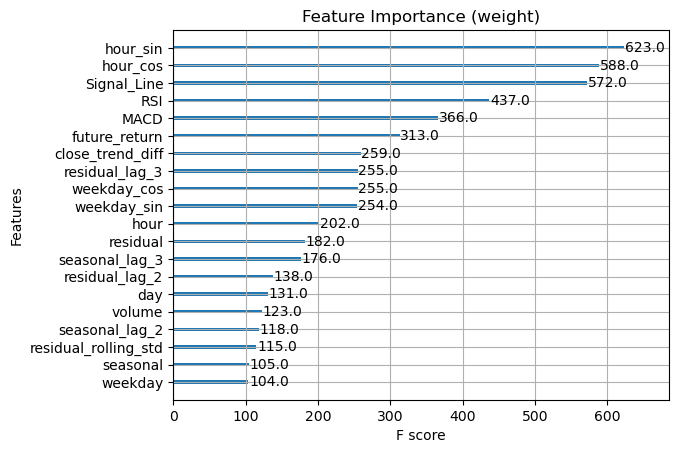

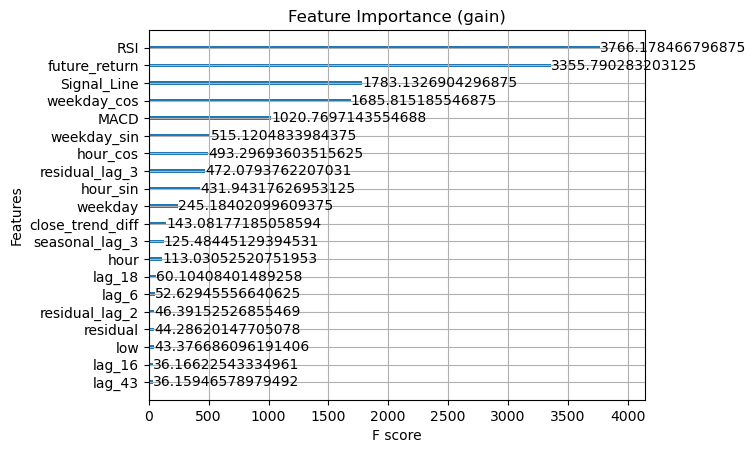

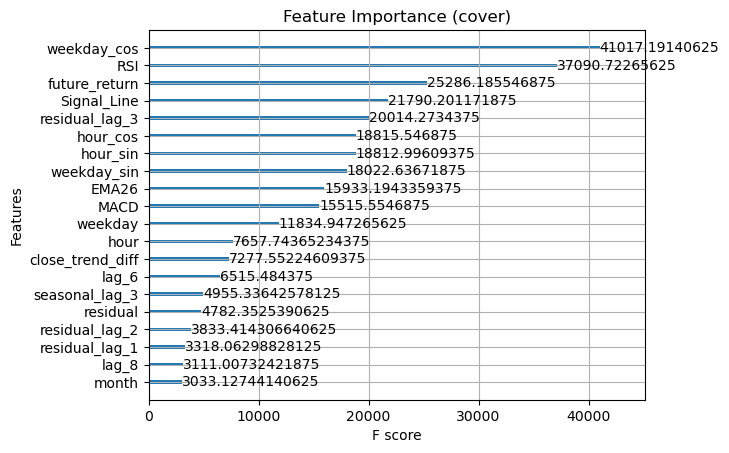

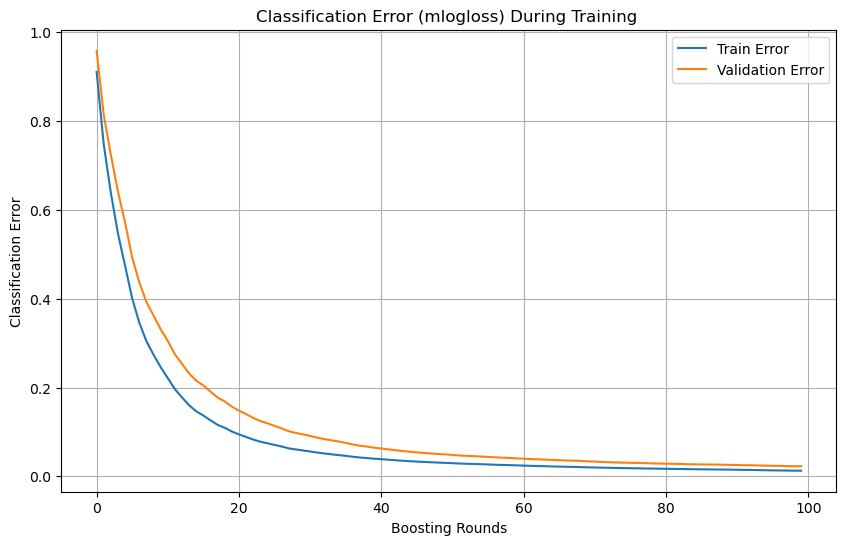

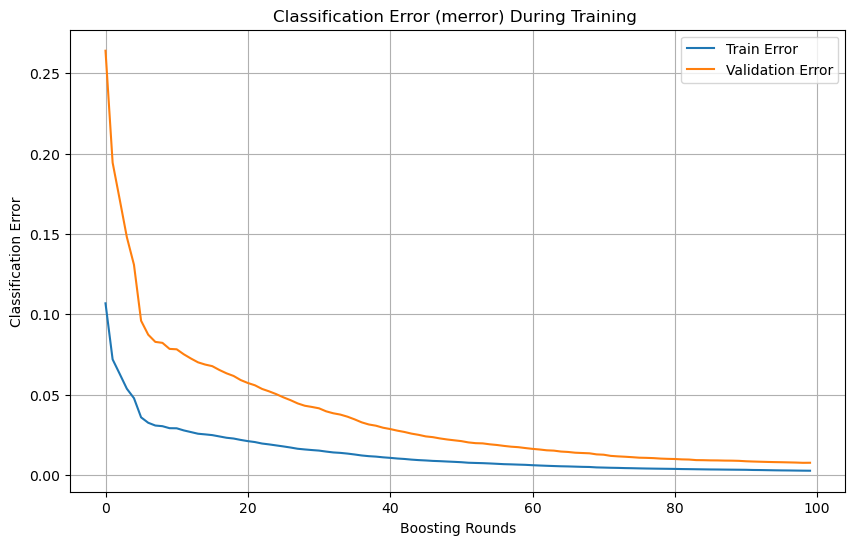


Calculate the ROC-AUC score for each class individually to see how well the model performs for the minority classes

ROC-AUC Score: 0.9883054702853369
ROC-AUC per class [0, 1, 2]: [0.98240097 0.99178257 0.99073288]


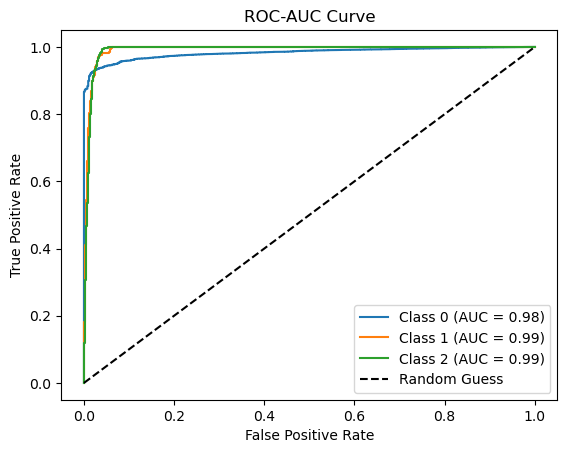

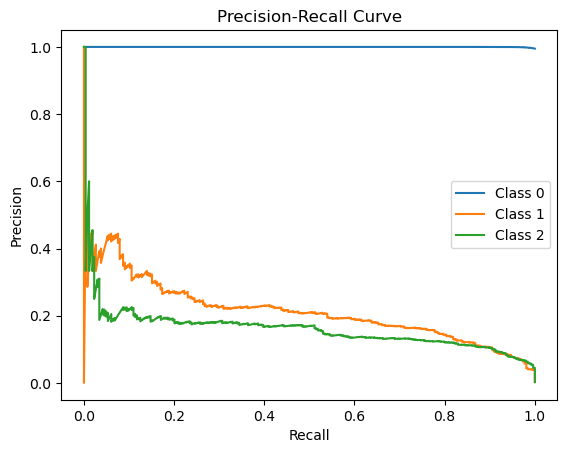

In [29]:
# Train with best params and 'adasyn'
start_mlflow_run(mlflow_run_name, use_optuna = False, n_splits = n_splits, initial_xgboost_model_parameters = best_xgb_model_params_adasyn)

In [32]:
best_xgb_model_params_smote = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': ['mlogloss', 'merror'],  
    'max_depth': 6, 
    'learning_rate': 0.17162175913961525,
    'n_estimators': 100, 
    # 'n_estimators': 242, 
    'subsample': 0.8348051679887819,
    'colsample_bytree': 0.7924327976006224, 
    'reg_alpha': 0.524354759427542,
    'reg_lambda': 0.06677336125564388,
    'min_child_weight': 2,
    'verbosity': 1,
    'random_state': 42,
    'n_jobs': 10
}

# Set oversampling_type to 'smote'
oversampling_type = 'smote'

n_splits = 2

# Set mlflow_run_name
posfix = '_train_best_model'
mlflow_run_name = f"BTC_{model_type}_{oversampling_type}{posfix}"
print(mlflow_run_name)

BTC_XGBoost_smote_train_best_model



model_params: {'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': ['mlogloss', 'merror'], 'max_depth': 6, 'learning_rate': 0.17162175913961525, 'n_estimators': 100, 'subsample': 0.8348051679887819, 'colsample_bytree': 0.7924327976006224, 'reg_alpha': 0.524354759427542, 'reg_lambda': 0.06677336125564388, 'min_child_weight': 2, 'verbosity': 1, 'random_state': 42, 'n_jobs': 10}
Original Class Distribution (SMOTE): [140260    308    386]
Balanced Class Distribution (SMOTE): [140260 140260 140260]

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    140141
           1       0.20      0.28      0.23       379
           2       0.19      0.34      0.24       433

    accuracy                           0.99    140953
   macro avg       0.46      0.54      0.49    140953
weighted avg       0.99      0.99      0.99    140953


model_params: {'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': ['m

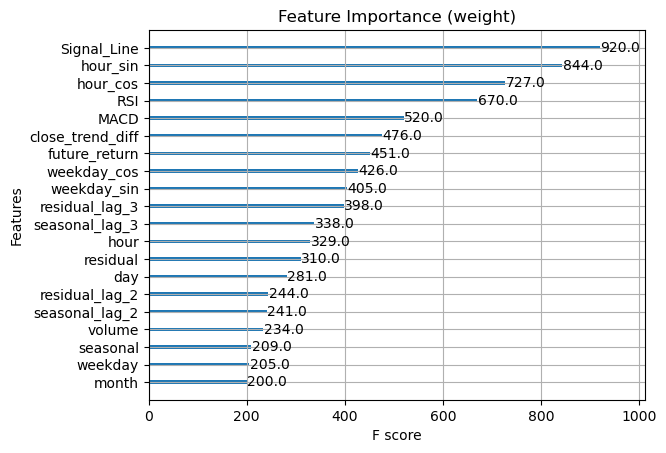

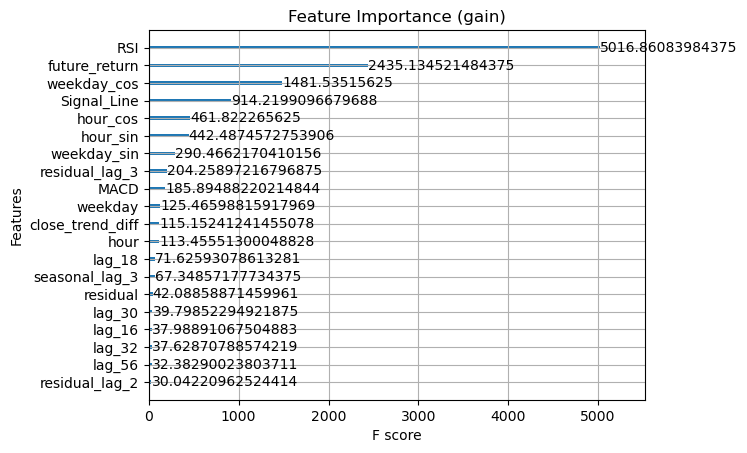

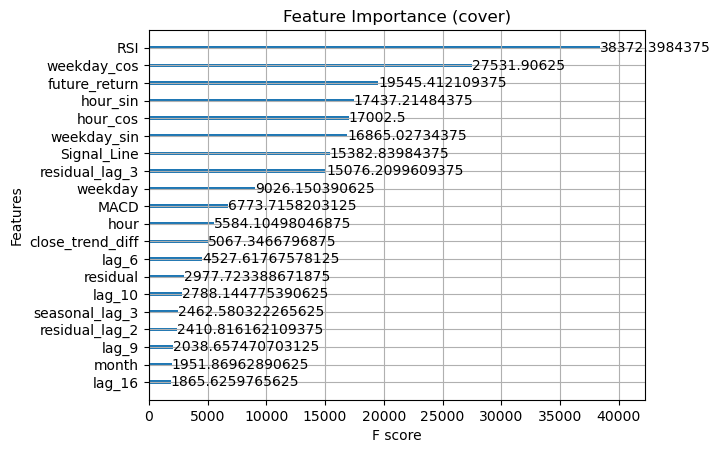

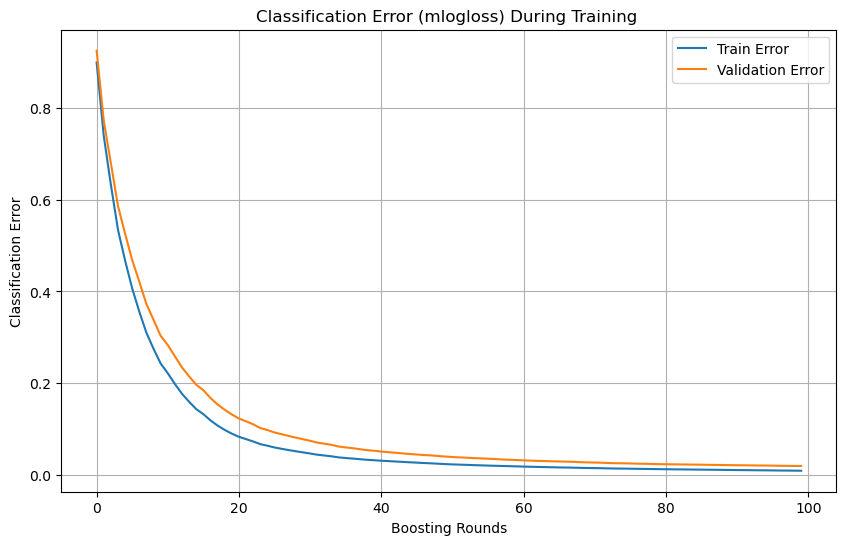

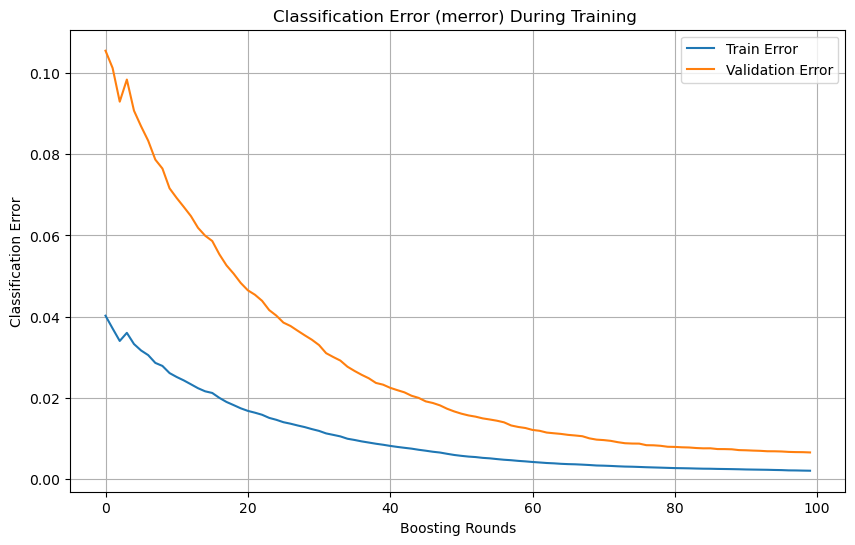


Calculate the ROC-AUC score for each class individually to see how well the model performs for the minority classes

ROC-AUC Score: 0.9891610402582351
ROC-AUC per class [0, 1, 2]: [0.98369009 0.99233717 0.99145585]


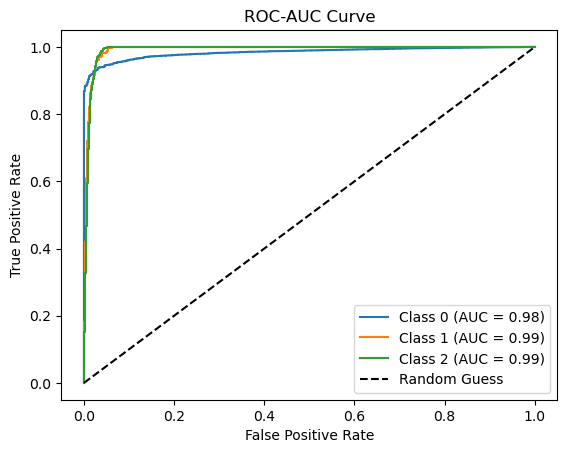

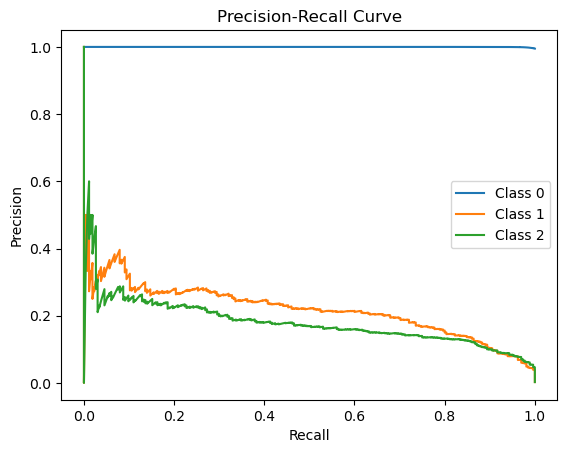

In [33]:
# Train with best params and 'smote'
start_mlflow_run(mlflow_run_name, use_optuna = False, n_splits = n_splits, initial_xgboost_model_parameters = best_xgb_model_params_smote)

### 5.2. GridSearchCV

In [36]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300],
    # 'n_estimators': [100, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 10, 50]
}

# Use TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits = n_splits)

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    scoring = 'f1_weighted',  # Use an appropriate scoring metric
    cv=tscv,                # Use TimeSeriesSplit
    verbose = 4,
    n_jobs=9
)

# grid_search.fit(attributes_train_smote, target_train_smote)
# print("Best Parameters:", grid_search.best_params_)

# Output best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best accuracy:", grid_search.best_score_)

# Evaluate on test set
# best_model = grid_search.best_estimator_
# test_score = best_model.score(attributes_test, target_test)
# print("Test set accuracy:", test_score)